# Food Recipe Generator

## Import Libraries

In [1]:
# Import necessary libraries
from tensorflow.keras.applications import ResNet152
from tensorflow.keras.layers import GlobalAveragePooling2D
from tensorflow import keras
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout
from tensorflow.keras.optimizers.legacy import Adam
import numpy as np
from sklearn.metrics import classification_report, confusion_matrix
import itertools
import matplotlib.pyplot as plt


## Constants and Paths

In [2]:
# Define constants and paths
im_shape = (256,256)
TRAINING_DIR = r'dataset/train'
TEST_DIR = r'dataset/test'
seed = 10
BATCH_SIZE = 64
epochs = 300

## Load the data generators

In [3]:
data_generator = ImageDataGenerator(
    validation_split=0.2,
    rotation_range=20,
    width_shift_range=0.2,
    height_shift_range=0.2,
    rescale=1./255,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    fill_mode='nearest'
)

val_data_generator = ImageDataGenerator(rescale=1./255, validation_split=0.2)

train_generator = data_generator.flow_from_directory(
    TRAINING_DIR, target_size=im_shape, shuffle=True, seed=seed,
    class_mode='categorical', batch_size=BATCH_SIZE, subset="training"
)

validation_generator = val_data_generator.flow_from_directory(
    TRAINING_DIR, target_size=im_shape, shuffle=False, seed=seed,
    class_mode='categorical', batch_size=BATCH_SIZE, subset="validation"
)

test_generator = ImageDataGenerator(rescale=1./255).flow_from_directory(
    TEST_DIR, target_size=im_shape, shuffle=False, seed=seed,
    class_mode='categorical', batch_size=BATCH_SIZE
)
global num_classes, nb_train_samples, nb_validation_samples, nb_test_samples, classes

nb_train_samples = train_generator.samples
nb_validation_samples = validation_generator.samples
nb_test_samples = test_generator.samples
classes = list(train_generator.class_indices.keys())
print('Classes: '+str(classes))
num_classes = len(classes)

Found 3200 images belonging to 80 classes.
Found 798 images belonging to 80 classes.
Found 958 images belonging to 80 classes.
Classes: ['Adhirasam', 'Aloo Gobi', 'Aloo Matar', 'Aloo Methi', 'Aloo Shimla Mirch', 'Aloo Tikki', 'Anarsa', 'Ariselu', 'Basundi', 'Bhatura', 'Bhindi Masala', 'Biryani', 'Boondi', 'Butter Chicken', 'Chak Hao Kheer', 'Cham Cham', 'Chana Masala', 'Chapati', 'Chhena Kheeri', 'Chicken Razala', 'Chicken Tikka', 'Chicken Tikka Masala', 'Chikki', 'Daal Baati Churma', 'Daal Puri', 'Dal Makhani', 'Dal Tadka', 'Dharwad Pedha', 'Doodhpak', 'Double Ka Meetha', 'Dum Aloo', 'Gajar Ka Halwa', 'Gavvalu', 'Ghevar', 'Gulab Jamun', 'Imarti', 'Jalebi', 'Kachori', 'Kadai Paneer', 'Kadhi Pakoda', 'Kajjikaya', 'Kakinada Khaja', 'Kalakand', 'Karela Bharta', 'Kofta', 'Kuzhi Paniyaram', 'Laddu', 'Lassi', 'Ledikeni', 'Litti Chokha', 'Lyangcha', 'Maach Jhol', 'Makki Di Roti Sarson Da Saag', 'Malapua', 'Misi Roti', 'Misti Doi', 'Modak', 'Mysore Pak', 'Naan', 'Navrattan Korma', 'Palak Panee

## Define the CNN mmodel

In [4]:
base_model = ResNet152(weights='imagenet', include_top=False, input_shape=(im_shape[0], im_shape[1], 3))
model = Sequential()
model.add(base_model)
model.add(GlobalAveragePooling2D())
model.add(Dense(512, activation='relu'))
model.add(Dropout(0.5))
model.add(Dense(num_classes, activation='softmax'))

Metal device set to: Apple M1 Max

systemMemory: 64.00 GB
maxCacheSize: 24.00 GB



## Compile and Train the model

In [5]:
model.compile(loss='categorical_crossentropy', optimizer=Adam(), metrics=['accuracy'])

callbacks_list = [
    keras.callbacks.ModelCheckpoint(filepath='model/best_model.h5', monitor='val_accuracy', save_best_only=True, verbose=1),
    #keras.callbacks.EarlyStopping(monitor='val_loss', patience=10, verbose=1)
]

history = model.fit(
    train_generator,
    steps_per_epoch=nb_train_samples // BATCH_SIZE,
    epochs=epochs,
    callbacks=callbacks_list,
    validation_data=validation_generator,
    verbose=1,
    validation_steps=nb_validation_samples // BATCH_SIZE
)


Epoch 1/300


loc("mps_select"("(mpsFileLoc): /AppleInternal/Library/BuildRoots/0783246a-4091-11ee-8fca-aead88ae2785/Library/Caches/com.apple.xbs/Sources/MetalPerformanceShadersGraph/mpsgraph/MetalPerformanceShadersGraph/Core/Files/MPSGraphUtilities.mm":294:0)): error: 'anec.gain_offset_control' op result #0 must be 4D/5D memref of 16-bit float or 8-bit signed integer or 8-bit unsigned integer values, but got 'memref<1x64x1x512xi1>'
loc("mps_select"("(mpsFileLoc): /AppleInternal/Library/BuildRoots/0783246a-4091-11ee-8fca-aead88ae2785/Library/Caches/com.apple.xbs/Sources/MetalPerformanceShadersGraph/mpsgraph/MetalPerformanceShadersGraph/Core/Files/MPSGraphUtilities.mm":294:0)): error: 'anec.gain_offset_control' op result #0 must be 4D/5D memref of 16-bit float or 8-bit signed integer or 8-bit unsigned integer values, but got 'memref<1x64x1x512xi1>'


50/50 [==============================] - ETA: 0s - loss: 4.4604 - accuracy: 0.0206
Epoch 1: val_accuracy improved from -inf to 0.01302, saving model to model/best_model.h5


/Library/Frameworks/Python.framework/Versions/3.9/lib/python3.9/site-packages/keras/src/engine/training.py:3000: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


50/50 [==============================] - 205s 2s/step - loss: 4.4604 - accuracy: 0.0206 - val_loss: 748.1485 - val_accuracy: 0.0130
Epoch 2/300
50/50 [==============================] - ETA: 0s - loss: 4.2888 - accuracy: 0.0347
Epoch 2: val_accuracy did not improve from 0.01302
50/50 [==============================] - 69s 1s/step - loss: 4.2888 - accuracy: 0.0347 - val_loss: 882.7305 - val_accuracy: 0.0130
Epoch 3/300
50/50 [==============================] - ETA: 0s - loss: 4.1756 - accuracy: 0.0369
Epoch 3: val_accuracy did not improve from 0.01302
50/50 [==============================] - 69s 1s/step - loss: 4.1756 - accuracy: 0.0369 - val_loss: 4.7964 - val_accuracy: 0.0130
Epoch 4/300
50/50 [==============================] - ETA: 0s - loss: 4.0661 - accuracy: 0.0350
Epoch 4: val_accuracy did not improve from 0.01302
50/50 [==============================] - 69s 1s/step - loss: 4.0661 - accuracy: 0.0350 - val_loss: 4.8896 - val_accuracy: 0.0130
Epoch 5/300
50/50 [======================

## Visualize Training Curves

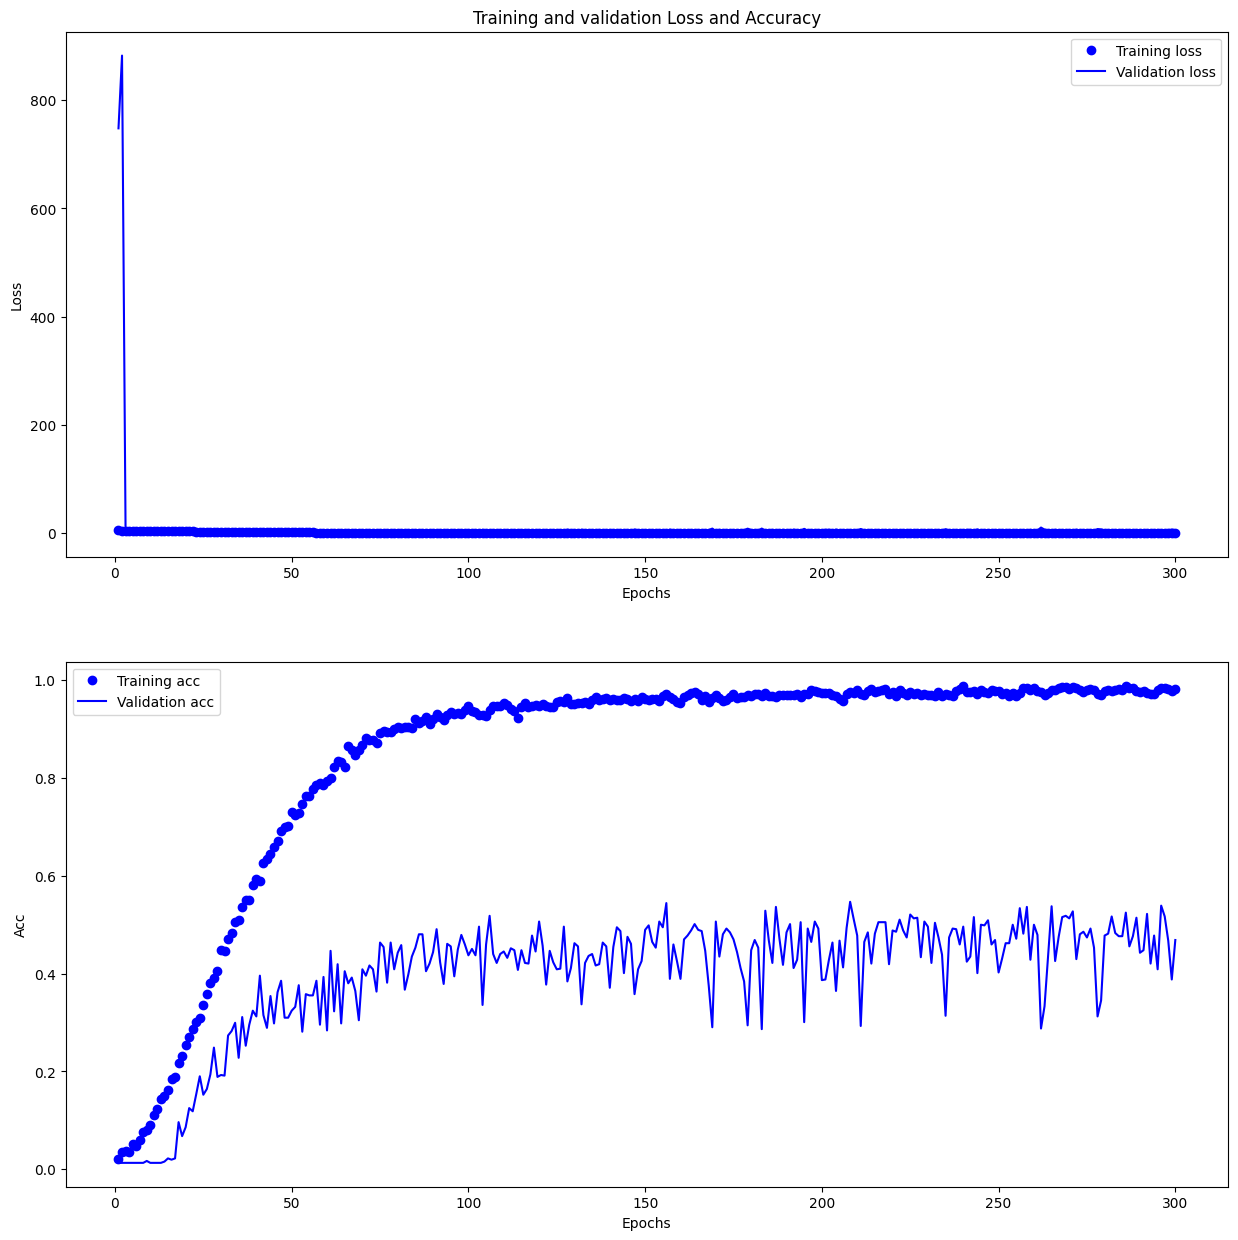

In [16]:
history_dict = history.history
loss_values = history_dict['loss']
val_loss_values = history_dict['val_loss']

epochs_x = range(1, len(loss_values) + 1)
plt.figure(figsize=(15,15))
plt.subplot(2,1,1)
plt.plot(epochs_x, loss_values, 'bo', label='Training loss')
plt.plot(epochs_x, val_loss_values, 'b', label='Validation loss')
plt.title('Training and validation Loss and Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.subplot(2,1,2)
acc_values = history_dict['accuracy']
val_acc_values = history_dict['val_accuracy']
plt.plot(epochs_x, acc_values, 'bo', label='Training acc')
plt.plot(epochs_x, val_acc_values, 'b', label='Validation acc')
#plt.title('Training and validation accuracy')
plt.xlabel('Epochs')
plt.ylabel('Acc')
plt.legend()
plt.show()

## Evaluate the model on validation and test sets

In [7]:
best_model = keras.models.load_model('model/best_model.h5')
score_val = best_model.evaluate(validation_generator)
score_test = best_model.evaluate(test_generator)


15/15 [==============================] - 31s 2s/step - loss: 0.9982 - accuracy: 0.8695


In [8]:
print('Validation loss:', score_val[0])
print(f'\nValidation accuracy:{round(score_val[1]*100,2)}%')

print('\nTest loss:', score_test[0])
print(f'\nTest accuracy:{round(score_test[1]*100,2)}%')

Validation loss: 3.5746994018554688

Validation accuracy:55.26%

Test loss: 0.9981935024261475

Test accuracy:86.95%


## Plotting Test Images with Prediction

2/2 [==============================] - 1s 130ms/step


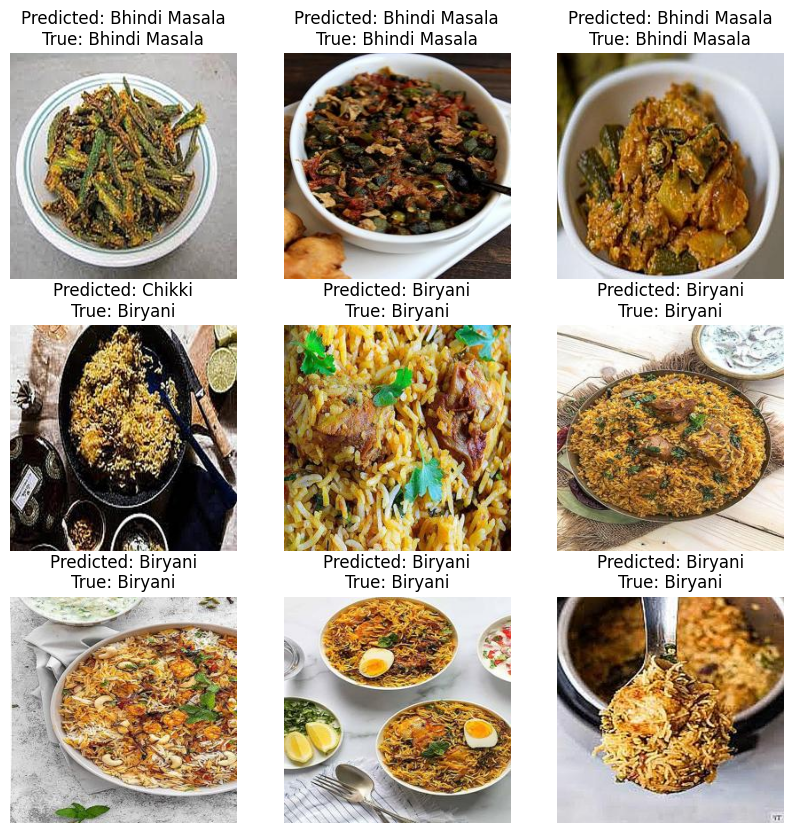

In [18]:
def plot_test_images_with_predictions(model, test_generator, num_images=9):
    test_images, true_labels = test_generator.next()
    predictions = model.predict(test_images)
    predicted_labels = [classes[np.argmax(pred)] for pred in predictions]

    plt.figure(figsize=(10, 10))
    for i in range(num_images):
        plt.subplot(3, 3, i + 1)
        plt.imshow(test_images[i])
        plt.title(f'Predicted: {predicted_labels[i]}\nTrue: {classes[np.argmax(true_labels[i])]}')
        plt.axis('off')

    plt.show()

# Plot test images with predictions
plot_test_images_with_predictions(best_model, test_generator, num_images=9)


In [10]:
Y_pred = best_model.predict(test_generator)
y_pred = np.argmax(Y_pred, axis=1)
target_names = classes

15/15 [==============================] - 71s 3s/step


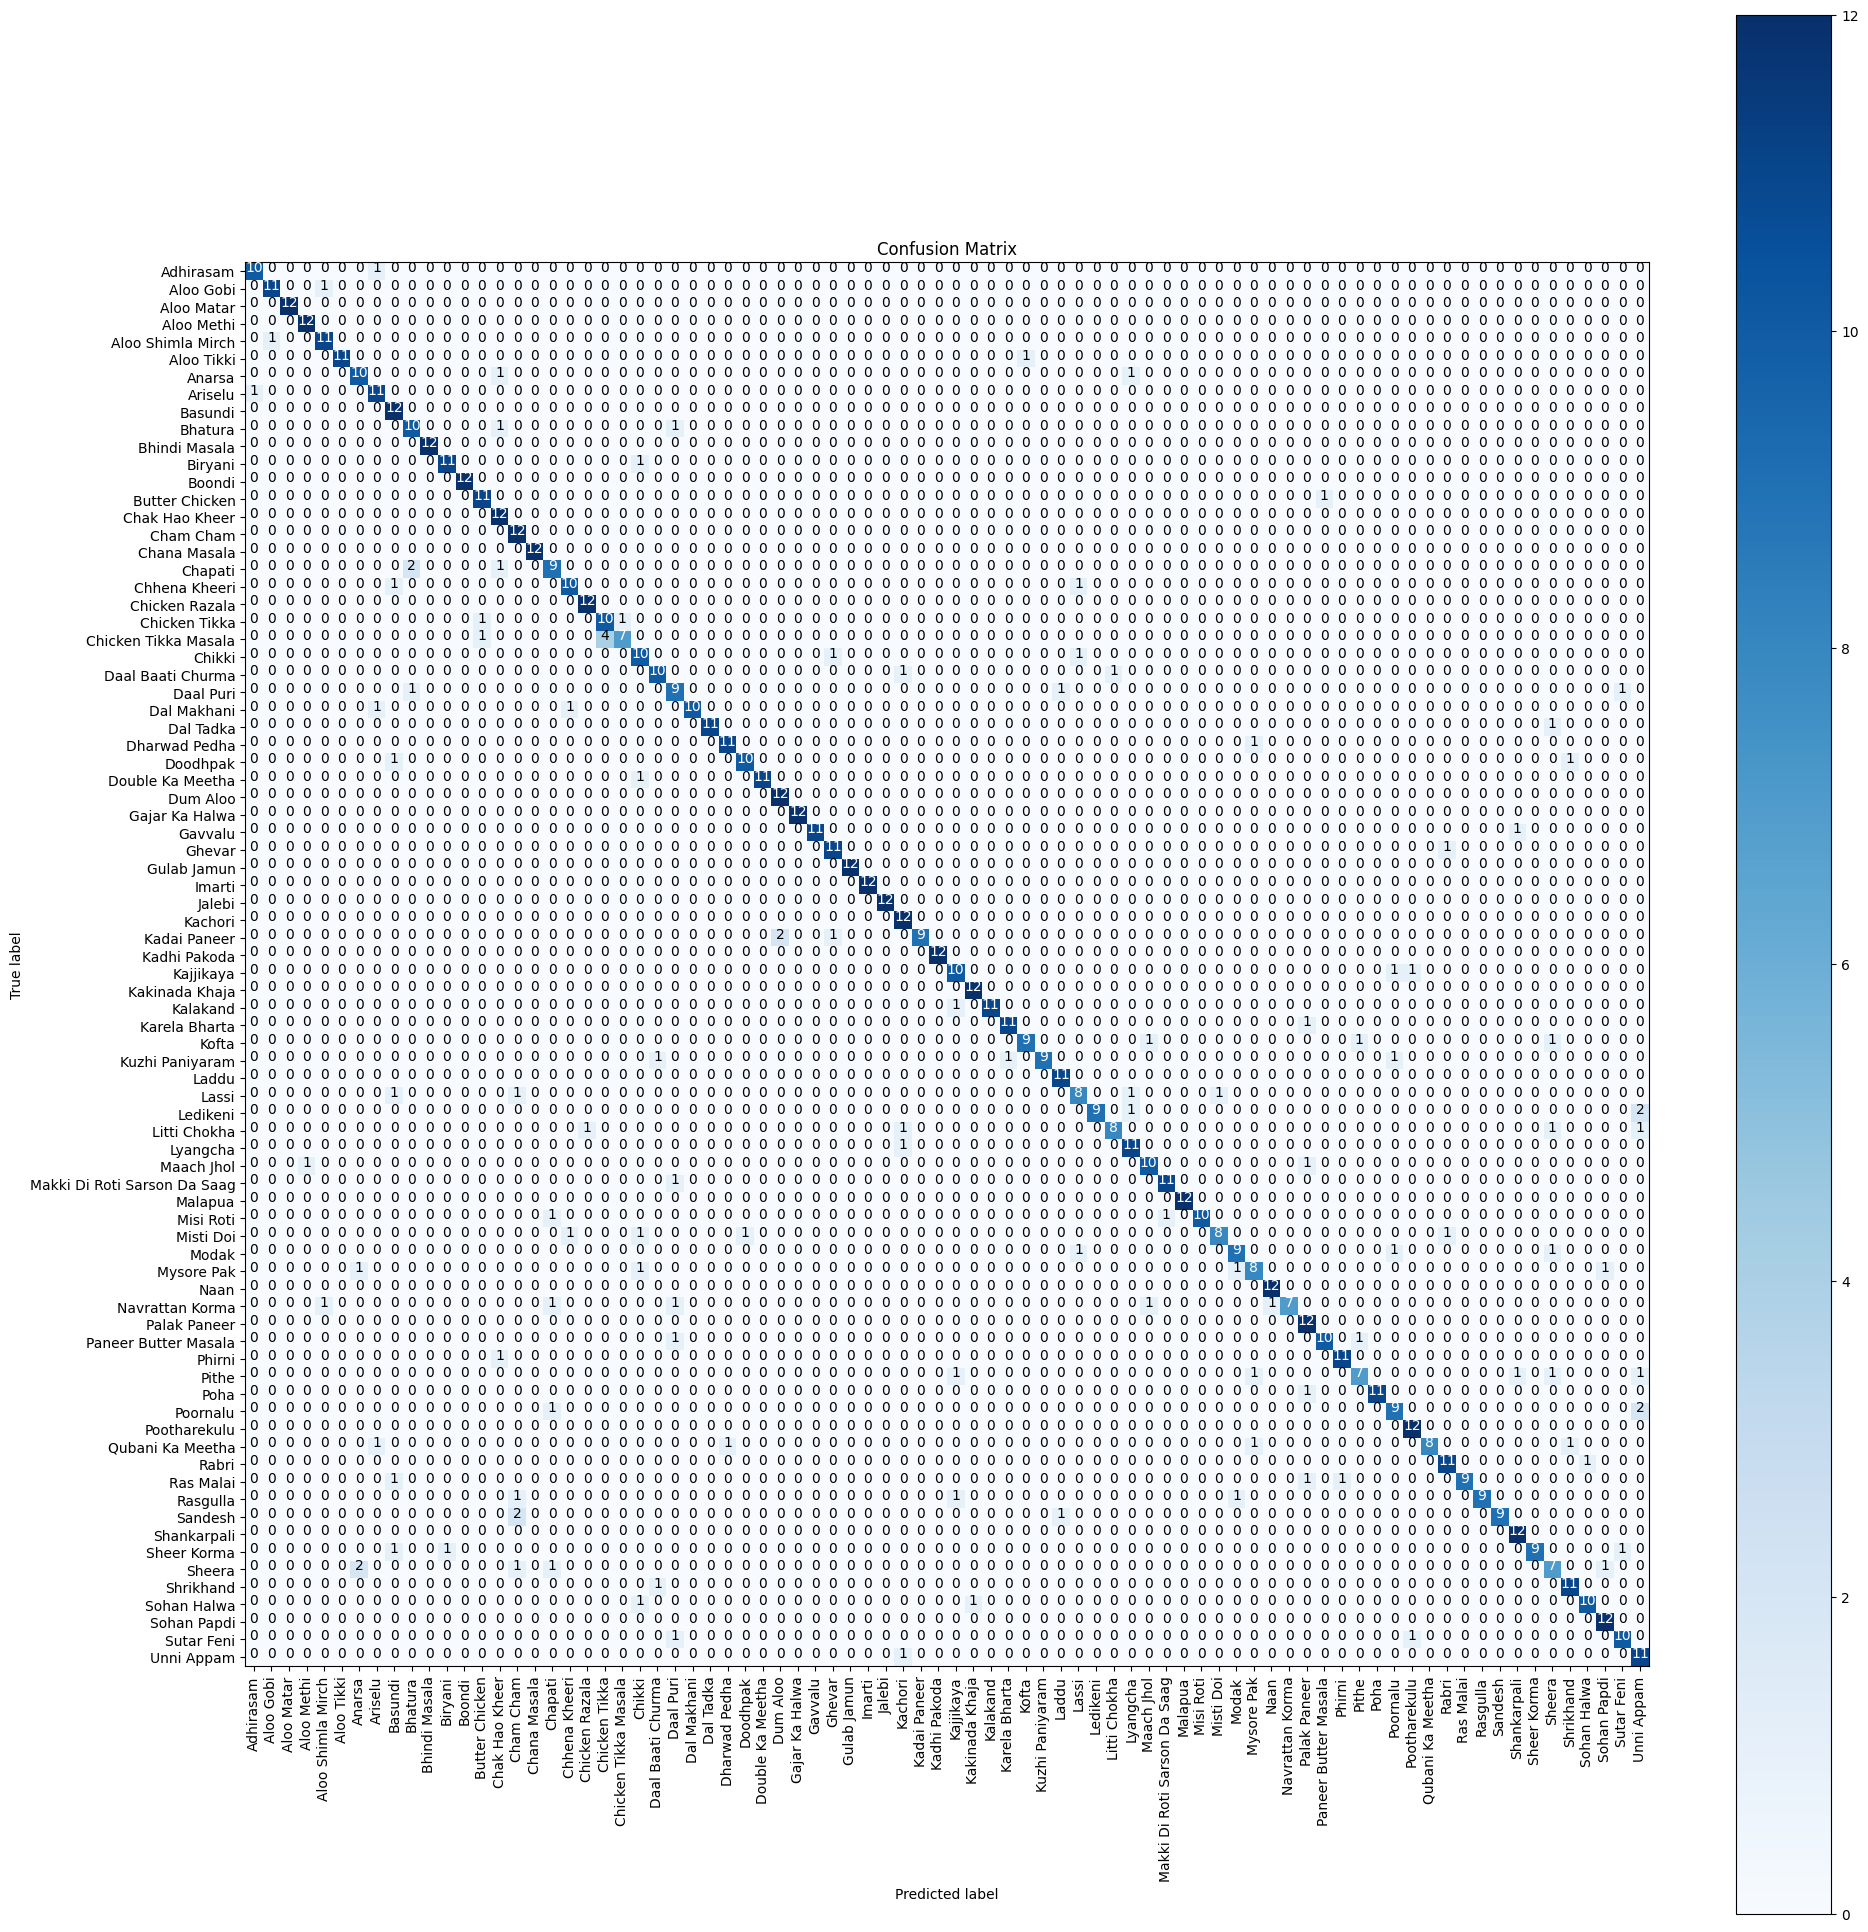

In [11]:
#Plot the confusion matrix. Set Normalize = True/False
def plot_confusion_matrix(cm, classes, normalize=True, title='Confusion matrix', cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    plt.figure(figsize=(20,20))
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=90)
    plt.yticks(tick_marks, classes)
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        cm = np.around(cm, decimals=2)
        cm[np.isnan(cm)] = 0.0
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, cm[i, j],
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")
    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

#Confution Matrix
cm = confusion_matrix(test_generator.classes, y_pred)
plot_confusion_matrix(cm, target_names, normalize=False, title='Confusion Matrix')



In [12]:
#Classification Report
print('Classification Report')
print(classification_report(test_generator.classes, y_pred, target_names=target_names))

Classification Report
                              precision    recall  f1-score   support

                   Adhirasam       0.91      0.91      0.91        11
                   Aloo Gobi       0.92      0.92      0.92        12
                  Aloo Matar       1.00      1.00      1.00        12
                  Aloo Methi       0.92      1.00      0.96        12
           Aloo Shimla Mirch       0.85      0.92      0.88        12
                  Aloo Tikki       1.00      0.92      0.96        12
                      Anarsa       0.77      0.83      0.80        12
                     Ariselu       0.79      0.92      0.85        12
                     Basundi       0.71      1.00      0.83        12
                     Bhatura       0.77      0.83      0.80        12
               Bhindi Masala       1.00      1.00      1.00        12
                     Biryani       0.92      0.92      0.92        12
                      Boondi       1.00      1.00      1.00        

## Inference

1/1 [==============================] - 30s 30s/step


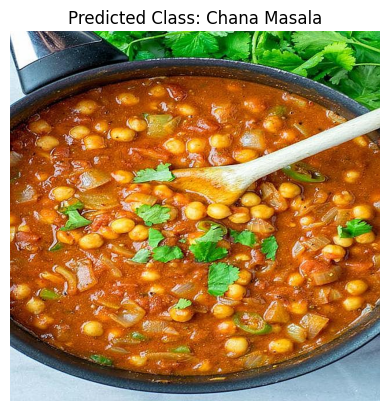

In [13]:
from tensorflow.keras.models import load_model
from tensorflow.keras.preprocessing import image

# Load the pre-trained model
model = load_model('model/best_model.h5')

# Function to preprocess the input image
def preprocess_input_image(img_path):
    img = image.load_img(img_path, target_size=(256,256))
    img = image.img_to_array(img)
    img = np.expand_dims(img, axis=0)
    img = img / 255.0  # Normalize the image
    return img

# Function to predict the class of the object in the image
def predict_class(img_path, model):
    preprocessed_img = preprocess_input_image(img_path)
    predictions = model.predict(preprocessed_img)
    class_index = np.argmax(predictions)
    predicted_class_label = classes[class_index]
    img = image.load_img(img_path)
    plt.imshow(img)
    plt.axis('off')
    plt.title('Predicted Class: ' + predicted_class_label)
    plt.show()
    return predicted_class_label


input_image_path = 'test1.jpg'

predicted_class_label=predict_class(input_image_path, model)


## Recipe Generation

In [14]:
import pandas as pd

recipe_data=pd.read_csv('dataset/recipe.csv')

# Function to get the recipe values of the predicted class
def get_recipe(predicted_class_label, recipe_data):
    # Find the row where the 'Name' column matches the predicted class label
    recipe = recipe_data.loc[recipe_data['Name'] == predicted_class_label]
    ingredients=recipe["Ingredients"].values[0]
    procedure=recipe["Procedure"].values[0]
    serving=recipe["Serving"].values[0]
    print(f"Recipe for {predicted_class_label}\n\nIngredients : {ingredients}\nProcedure : {procedure}\nServing : {serving}")
    return None

get_recipe(predicted_class_label, recipe_data)


Recipe for Chana Masala

Ingredients : Chickpeas, Onions, Tomatoes, Ginger-garlic paste, Green chilies, Coriander powder, Cumin seeds, Garam masala, Oil, Salt
Procedure : Cook chickpeas and sauté with onions, tomatoes, and spices. Garnish with fresh coriander leaves.
Serving : Serve hot with rice or naan.


1/1 [==============================] - 0s 80ms/step


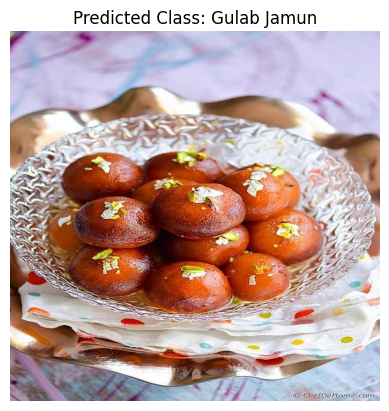

Recipe for Gulab Jamun

Ingredients : Khoya, Paneer, All-purpose flour, Milk powder, Ghee, Milk, Sugar, Cardamom powder, Oil for frying
Procedure : Mix khoya, paneer, all-purpose flour, and milk powder to form a dough. Shape into balls and deep fry until golden brown. Soak in sugar syrup.
Serving : Serve as a sweet dessert.


In [15]:
input_image_path = 'test2.jpg'
predicted_class_label=predict_class(input_image_path, model)
get_recipe(predicted_class_label, recipe_data)